# PARAMETERS

In [1]:
####### INFERENCE CONFIGURATION

class CFG:
    
    # environment
    environment  = 'local'  # work environment ['kaggle', 'local']
    num_workers = 2         # no. cores
    debug       = False     # debug runs inference on a subset of training images
    
    # general
    seed = 13353  # random state
    
    # blending
    scaling     = False
    fold_blend  = 'gmean'  # how to blend folds  ['amean', 'median', 'gmean', 'pmean', 'rmean']
    model_blend = 'gmean'  # how to blend models ['amean', 'median', 'gmean', 'pmean', 'rmean']
    power       = 1e-2     # power parameter for pmean
    
    
    # stacking 
    w_stack         = 1         # weight of stacking in final ensemble
    lgb_folds       = 5         # no. folds for stacking
    lgb_stop_rounds = 200       # no. early stopping rounds
    lgb_params      = {'objective':         'binary',
                       'metrics':           'auc',
                       'n_estimators':      10000,
                       'learning_rate':     0.01,
                       'num_leaves':        16,
                       'max_depth':         3,
                       'min_child_samples': 20,
                       'subsample':         0.8,
                       'colsample_bytree':  0.8,
                       'reg_alpha':         0.01,
                       'reg_lambda':        0.01,
                       'silent':            True,
                       'verbosity':         -1,
                       'n_jobs' :           4,
                       'random_state':      13353}
    
    # paths
    data_path = '../input/'
    out_path  = '../output/blend/'
    
    # models
    models = [
             '../output/v11/',
             '../output/v12/',
             '../output/v13/',
             '../output/v14/',
             '../output/v15/',
             '../output/v16/',
             ]

In [2]:
####### CONVERT CONFIGURATION

CFG = dict(vars(CFG))
for key in ['__dict__', '__doc__', '__module__', '__weakref__']:
    del CFG[key]

# PREPARATIONS

In [3]:
####### PACKAGES

import numpy as np
import pandas as pd

import torch

import lightgbm as lgb

from scipy.special import softmax
from scipy.stats import gmean

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import preprocessing

from tqdm.auto import tqdm

import random
import time
import sys
import os

import gc; gc.enable()

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings

In [4]:
####### MODULES

sys.path.append('../code')  

from utilities import get_score, compute_blend, seed_everything

In [5]:
####### ENVIRONMENT SETTINGS

pd.options.display.max_columns = 100  # maximum displayed columns
warnings.filterwarnings('ignore')      # ignoring warnings
seed_everything(CFG['seed'])          # random seed

- setting random seed to 13353...


# DATA PREP

In [6]:
####### IMPORT OOF PREDS

for m in CFG['models']:

    tmp_train_preds         = pd.read_csv(m + '/oof.csv')
    tmp_train_preds.columns = ['id', 'target', 'file_path', 'fold'] + [str(m) + 'pred']
    
    if CFG['scaling']:
        for fold in range(tmp_train_preds['fold'].max()):
            tmp_train_preds.loc[tmp_train_preds['fold'] == fold, str(m) + 'pred'] = tmp_train_preds.loc[tmp_train_preds['fold'] == fold, str(m) + 'pred'].rank(pct = True)

    if m == CFG['models'][0]:
        train_preds = tmp_train_preds        
    else:
        train_preds = train_preds.merge(tmp_train_preds[['id'] + [str(m) + 'pred']], how = 'left', on = 'id')
        
train_preds.shape

(560000, 10)

In [7]:
####### IMPORT TEST PREDS

for m in CFG['models']:

    tmp_test_preds         = pd.read_csv(m + '/submission.csv')
    tmp_test_preds.columns = ['id'] + [str(m) + p for p in ['pred0', 'pred1', 'pred2', 'pred3', 'pred4']]
    
    if CFG['scaling']:
        for fold in range(5):
            tmp_test_preds[str(m) + 'pred' + str(fold)] = tmp_test_preds[str(m) + 'pred' + str(fold)].rank(pct = True)


    if m == CFG['models'][0]:
        test_preds = tmp_test_preds        
    else:
        test_preds = test_preds.merge(tmp_test_preds[['id'] + [str(m) + p for p in ['pred0', 'pred1', 'pred2', 'pred3', 'pred4']]], how = 'left', on = 'id')
        
test_preds.shape

(226000, 31)

# BLENDING

In [8]:
####### CHECK OOF PERFORMANCE

# sort models by performance
weights = []
for model_idx, m in enumerate(CFG['models']):
    score = 0
    for fold_idx in range(5):
        tmp_train_preds = train_preds.loc[train_preds['fold'] == fold_idx]
        score += get_score(tmp_train_preds['target'].values, 
                           tmp_train_preds[str(m) + 'pred'].values) / 5
    weights.append(score)
sorted_ids     = list(np.argsort(np.array(weights)))
sorted_weights = [weights[i] for i in sorted_ids]
CFG['models']  = [CFG['models'][i] for i in sorted_ids]

# display performance 
print('-' * 31)
print('{:<5}{:<20}{:>5}'.format('ID', 'Model', 'AUC'))
print('-' * 31)
for model_idx, m in enumerate(CFG['models']):
    print('{:<5}{:<20}{:.4f}'.format(model_idx + 1, m, sorted_weights[model_idx]))
print('-' * 31)

-------------------------------
ID   Model                 AUC
-------------------------------
1    ../output/v14/      0.8370
2    ../output/v16/      0.8381
3    ../output/v11/      0.8628
4    ../output/v12/      0.8635
5    ../output/v15/      0.8644
6    ../output/v13/      0.8657
-------------------------------


In [9]:
####### CHECK BLEND PERFORMANCE

# compute predcitions
preds = train_preds.filter(like = 'output').columns
for blend in ['amean', 'median', 'gmean', 'pmean', 'rmean']:
    train_preds[blend] = compute_blend(train_preds, preds, blend, CFG)
for blend in ['amean', 'median', 'gmean', 'pmean', 'rmean']:
    train_preds['w' + blend] = compute_blend(train_preds, preds, blend, CFG, weights = np.array(sorted_weights))

# compute performance
print('-' * 16)
print('{:<10}{:>5}'.format('Blend', 'AUC'))
print('-' * 16)
for blend in ['amean', 'median', 'gmean', 'pmean', 'rmean']:
    score = 0
    for fold_idx in range(5):
        tmp_train_preds = train_preds.loc[train_preds['fold'] == fold_idx]
        score += get_score(tmp_train_preds['target'].values, 
                           tmp_train_preds[blend].values) / 5
    print('{:<10}{:>5.4f}'.format(blend, score))    
print('-' * 16)
for blend in ['amean', 'median', 'gmean', 'pmean', 'rmean']:
    score = 0
    for fold_idx in range(5):
        tmp_train_preds = train_preds.loc[train_preds['fold'] == fold_idx]
        score += get_score(tmp_train_preds['target'].values, 
                           tmp_train_preds['w' + blend].values) / 5
    print('{:<10}{:>5.4f}'.format('w' + blend, score))    
print('-' * 16)

----------------
Blend       AUC
----------------
amean     0.8695
median    0.8692
gmean     0.8693
pmean     0.8693
rmean     0.8686
----------------
wamean    0.8695
wmedian   0.8692
wgmean    0.8693
wpmean    0.8693
wrmean    0.8686
----------------


In [10]:
####### EXPORT BEST BLEND [OOF]

# select best blend
best_blend = 'gmean'

# export CSV
oof_blend = train_preds[['id', 'target', best_blend]].copy()
oof_blend.columns = ['id', 'target', 'pred']
oof_blend.to_csv(CFG['out_path'] + 'oof_{}.csv'.format(best_blend), index = False)
oof_blend.head()

,id,target,pred
0,00001f4945,0,0.254848
1,0002402e11,0,0.343764
2,00026ce3c5,0,0.182756
3,000288e4a5,1,0.999919
4,0002b64784,1,0.195459


In [11]:
####### EXPORT BEST BLEND [TEST]

# blend fold predictions
print('Blending fold predictions with: ' + CFG['fold_blend'])
for m in CFG['models']:
    preds = test_preds.filter(like = m).columns
    test_preds[m + 'pred'] = compute_blend(test_preds, preds, CFG['fold_blend'], CFG)
    test_preds.drop(preds, axis = 1, inplace = True)
    
# blend model predictions
print('Blending model predictions with: ' + CFG['model_blend'])
preds = test_preds.filter(like = 'output').columns
test_preds['pred'] = compute_blend(test_preds, preds, CFG['model_blend'], CFG) 

# save CSV
test_blend = test_preds[['id', 'pred']].copy()   
test_blend.to_csv(CFG['out_path'] + 'sub_{}.csv'.format(best_blend), index = False)
test_blend.head()

Blending fold predictions with: gmean
Blending model predictions with: gmean


,id,pred
0,00005bced6,0.999935
1,0000806717,0.809193
2,0000ef4fe1,0.347922
3,00020de251,0.642376
4,00024887b5,0.186316


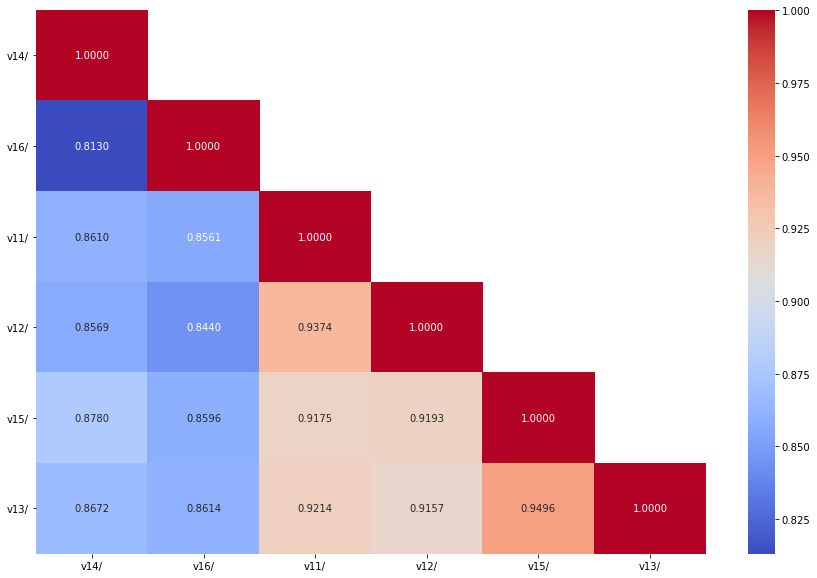

In [12]:
####### CHECK MODEL OOF CORRELATION

corr    = train_preds[[m + 'pred' for m in CFG['models']]].corr(method = 'spearman')
corr    = corr.where(np.tril(np.ones(corr.shape)).astype(np.bool))
fig, ax  = plt.subplots(figsize = (15, 10))
ticks   = [m.replace('../output/', '') for m in CFG['models']]
hmap    = sns.heatmap(corr, cmap = 'coolwarm', annot = corr, fmt = '.4f', xticklabels = ticks, yticklabels = ticks)
plt.yticks(rotation = 0)
plt.show()

# STACKING

In [13]:
####### TRANSFORM DATA

y      = train_preds['target']
X      = train_preds.copy()
X_test = test_preds.copy()
print(X.shape, y.shape)
print(X_test.shape)

(560000, 20) (560000,)
(226000, 8)


In [14]:
####### SELECT RELEVANT FEATURES

features      = list(X_test.columns)
drop_features = ['id', 'pred'] 
features      = [f for f in features if f not in drop_features]
print(len(features), 'features')
features

6 features


['../output/v14/pred',
 '../output/v16/pred',
 '../output/v11/pred',
 '../output/v12/pred',
 '../output/v15/pred',
 '../output/v13/pred']

In [15]:
####### STACKING LOOP

# placeholders
oof_preds     = np.zeros(len(X))
oof_scores    = []
all_lgb_preds = None
importances   = pd.DataFrame()

# cross-validation
for fold in range(CFG['lgb_folds']):
    
    # extract indices
    trn_idx = X.loc[X['fold'] != fold].index
    val_idx = X.loc[X['fold'] == fold].index

    # placeholders
    lgb_preds = np.zeros(len(X_test))

    # extract samples
    X_train, y_train = X.iloc[trn_idx][features], y.iloc[trn_idx]
    X_valid, y_valid = X.iloc[val_idx][features], y.iloc[val_idx]
    X_test           = X_test[features]

    # modeling
    clf = lgb.LGBMRegressor(**CFG['lgb_params']) 
    clf = clf.fit(X_train, y_train, 
                  eval_set              = [(X_train, y_train), (X_valid, y_valid)],
                  early_stopping_rounds = CFG['lgb_stop_rounds'],
                  verbose               = 200)

    # prediction
    oof_preds[val_idx] = clf.predict(X_valid)
    lgb_preds          = clf.predict(X_test)

    # save preditions
    lgb_preds     = pd.DataFrame(lgb_preds, columns = ['lgb_fold{}'.format(fold)])
    all_lgb_preds = pd.concat([all_lgb_preds, lgb_preds], axis = 1)

    # feature importance
    fold_importance_df               = pd.DataFrame()
    fold_importance_df['Feature']    = features
    fold_importance_df['Importance'] = clf.feature_importances_
    importances = pd.concat([importances, fold_importance_df], axis = 0)

    # information
    oof_scores.append(get_score(y_valid, oof_preds[val_idx]))
    print('-' * 65)
    print('FOLD {}/{}: AUC = {:.4f}'.format(fold + 1, CFG['lgb_folds'], oof_scores[fold]))
    print('-' * 65)
    print(' ')
    print('-' * 65)

# print performance
print('OOF AUC = {:.4f}'.format(np.mean(oof_scores))) 
print('-' * 65)

Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.870858	valid_1's auc: 0.867584
[400]	training's auc: 0.87123	valid_1's auc: 0.867993
[600]	training's auc: 0.8713	valid_1's auc: 0.868037
[800]	training's auc: 0.871338	valid_1's auc: 0.868037
Early stopping, best iteration is:
[699]	training's auc: 0.871317	valid_1's auc: 0.868041
-----------------------------------------------------------------
FOLD 1/5: AUC = 0.8680
-----------------------------------------------------------------
 
-----------------------------------------------------------------
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.869318	valid_1's auc: 0.871318
[400]	training's auc: 0.869649	valid_1's auc: 0.871562
[600]	training's auc: 0.869728	valid_1's auc: 0.871589
[800]	training's auc: 0.86977	valid_1's auc: 0.871596
Early stopping, best iteration is:
[790]	training's auc: 0.869767	valid_1's auc: 0.871596
-------------------------------------

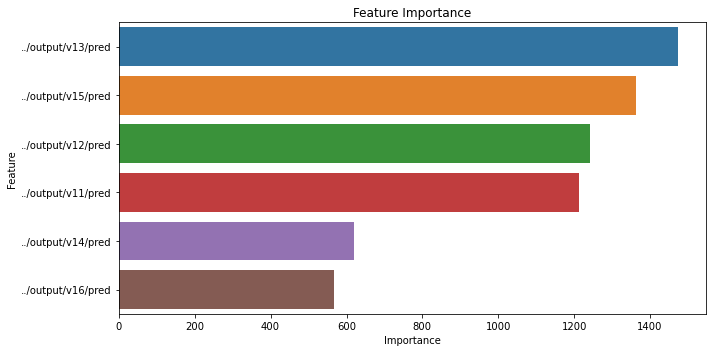

In [16]:
###### FEATURE IMPORTANCE

fig   = plt.figure(figsize = (10, 5))
cols = importances[['Feature', 'Importance']].groupby('Feature').mean().sort_values(by = 'Importance', ascending = False).index
importance = importances.loc[importances.Feature.isin(cols)].groupby('Feature').mean().reset_index(drop = False)
sns.barplot(x = 'Importance', y = 'Feature', data = importance.sort_values(by = 'Importance', ascending = False), ci = 0)
plt.title('Feature Importance')
plt.tight_layout()

In [17]:
####### BLEND FOLD PREDICTIONS

# copy predictions
test_preds_lgb       = all_lgb_preds.copy()
test_preds_lgb['id'] = test_preds['id']

# blend folds
print('Blending fold predictions with: ' + CFG['fold_blend'])
preds = ['lgb_fold' + str(fold) for fold in range(CFG['lgb_folds'])]
test_preds_lgb['pred'] = compute_blend(test_preds_lgb, preds, CFG['fold_blend'], CFG)
test_preds_lgb.drop(preds, axis = 1, inplace = True)
test_preds_lgb.head()

Blending fold predictions with: gmean


,id,pred
0,00005bced6,0.999853
1,0000806717,0.953652
2,0000ef4fe1,0.309009
3,00020de251,0.862001
4,00024887b5,0.177634


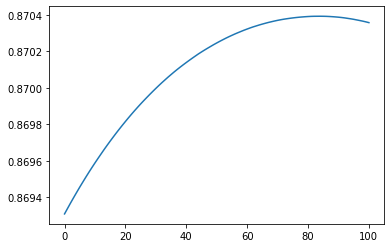

- optimal weight of stacking:  0.8400
- AUC of blend-stack ensemble: 0.8704


In [18]:
####### OPTIMAL STACKING WEIGHT

# placeholders
score_steps = 100
scores      = []

# optimize stacking weight
for a in range(score_steps + 1):
    w    = a / score_steps
    train_preds['ensemble'] = oof_preds * w + oof_blend['pred'] * (1 - w)
    score = 0
    for fold_idx in range(5):
        tmp_train = train_preds.loc[train_preds['fold'] == fold_idx]
        score += get_score(tmp_train['target'].values, 
                           tmp_train['ensemble'].values) / 5
    scores.append(score)
plt.plot(scores)
plt.show()

# feedback
w_stack = scores.index(max(scores)) / score_steps
print('- optimal weight of stacking:  {:.4f}'.format(w_stack))
print('- AUC of blend-stack ensemble: {:.4f}'.format(max(scores)))

# SUBMISSION

In [19]:
####### ENSEMBLING BLEND AND STACKING

print('Ensembling: {:.2f} * blend + {:.2f} * stacking'.format(1 - CFG['w_stack'], CFG['w_stack']))
final_preds         = test_preds.copy()
final_preds['pred'] = test_preds['pred'] * (1 - CFG['w_stack']) + test_preds_lgb['pred'] * CFG['w_stack']
final_preds.head()

Ensembling: 0.00 * blend + 1.00 * stacking


,id,../output/v14/pred,../output/v16/pred,../output/v11/pred,../output/v12/pred,../output/v15/pred,../output/v13/pred,pred
0,00005bced6,0.999902,0.999902,1.000000,1.000000,1.000000,0.999805,0.999853
1,0000806717,0.528404,0.656319,0.905429,0.949375,0.993442,0.947974,0.953652
2,0000ef4fe1,0.447007,0.388123,0.370153,0.269904,0.284320,0.359921,0.309009
3,00020de251,0.441438,0.270129,0.824096,0.898768,0.954352,0.833611,0.862001
4,00024887b5,0.167886,0.189600,0.254582,0.188688,0.178086,0.153619,0.177634


In [20]:
####### SUBMISSION FILE

sub = final_preds[['id', 'pred']].copy()   
sub.columns = ['id', 'target']
#sub['target'] = sub['target'].rank(pct = True)
sub.to_csv(CFG['out_path'] + 'submission.csv', index = False)
display(sub.head())

,id,target
0,00005bced6,0.999853
1,0000806717,0.953652
2,0000ef4fe1,0.309009
3,00020de251,0.862001
4,00024887b5,0.177634
